In [ ]:
from criminologia_cdmx.etl import *
from criminologia_cdmx.covariables import *
from criminologia_cdmx.modelos import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import contextily as ctx
from libpysal.weights import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
import warnings
plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

# Modelos

En este notebook vamos a desarrollar algunos flujos de trabajo completo para desarrollar, ajustar y comparar modelos criminológicos. 

## Robo a casa habitación sin violencia

El primer ejemplo completo que vamos a trabajar es sobre robo a casa habitación sin violencia. Lo que vamos a hacer es ajustar un modelo GLM utilizando sólo variables censales que describan la población y las viviendas de cada colonia y luego vamos a incluir alguinas variables de estructura urbana paracomparar los dos modelos

### Preparación de variable dependiente

Vamos a leer (desde un archivo) el total de las carpetas de investigación y realizaremos el siguiente preprocesamiento:

* Agregar ids espaciales (colonias y cuadrantes)
* Definimos fechas iniciales y finales para agregar los datos
* Usamos la función `variable_independiente` para extraere los datos entre las fechas de interés y agregar los incidentes en colonias

In [ ]:
carpetas = get_carpetas_desde_archivo("datos/descargas/carpetas_fiscalia.csv")
carpetas = agrega_ids_espaciales(carpetas)
fecha_inicio = "01-01-2019"
fecha_fin = "01-01-2022"
delito = ['ROBO A CASA HABITACION SIN VIOLENCIA']
Y = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)
Y

,colonia_cve,ROBO A CASA HABITACION SIN VIOLENCIA
0.0,1,0.0
1.0,2,2.0
2.0,3,4.0
3.0,4,7.0
4.0,5,8.0
...,...,...
1810.0,1811,1.0
1811.0,1812,3.0
1812.0,1813,0.0
1813.0,1814,5.0


### Variables censales

Ahora vamos a preparar una `CapaDeAnalisis` utilizando sólo datos censales. Primero leemos los datos del censo, los agregamos en colonias y los pasamos a tasas.

In [ ]:
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario)
agregado = censo_a_tasas(agregado, diccionario)
agregado.head()

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,OCUPVIVPAR,PROM_OCUP_C
colonia_cve,,,,,,,,,,,,,,,,,,,,,
0,7232.0,0.508573,0.491427,0.034015,0.013689,0.016178,0.961975,0.490874,0.471101,0.931831,...,0.656438,0.429589,0.305205,0.181370,0.010959,0.033425,0.340274,0.001644,7149.0,1.417609
1,1957.0,0.527338,0.472662,0.022483,0.008687,0.008176,0.975473,0.515074,0.460399,0.957588,...,0.714992,0.438221,0.276771,0.222405,0.000000,0.018122,0.240527,0.000000,1957.0,1.205049
2,3359.0,0.534088,0.465912,0.029175,0.010420,0.013695,0.968443,0.520393,0.448050,0.944329,...,0.715534,0.488350,0.321359,0.185437,0.002913,0.029126,0.240777,0.002913,3359.0,1.204806
3,2330.0,0.536910,0.463090,0.019742,0.003433,0.009871,0.978112,0.529185,0.448927,0.957511,...,0.860523,0.591532,0.459527,0.249066,0.003736,0.003736,0.129514,0.000000,2327.0,0.992747
4,4297.0,0.529905,0.470095,0.022807,0.007680,0.004887,0.974168,0.516407,0.457761,0.953921,...,0.706013,0.469933,0.276912,0.195991,0.002970,0.023014,0.254640,0.002227,4297.0,1.177906


Seleccionamos un par de variables que nos describan las viviendas en una colonia:

* Total de viviendas habitadas
* Viviendas con más de tres habitaciones

In [ ]:
vars_viv = agregado[['VIVPAR_HAB', 'VPH_3YMASC']]
vars_viv.head()

,VIVPAR_HAB,VPH_3YMASC
colonia_cve,,
0,1825.0,0.790137
1,607.0,0.762768
2,1030.0,0.793204
3,803.0,0.911582
4,1347.0,0.783222


Construimos un índice para representar la Concentración de Desventajas a partir de las variables de población del censo

In [ ]:
vars_indice = ['P5_HLI', 'POB_AFRO', 'PCON_DISC', 'P3A5_NOA', 
               'P6A11_NOA', 'P12A14NOA', 'P15YM_AN', 'PSINDER', 'PDESOCUP']
diccionario[diccionario['Nombre del Campo'].isin(vars_indice)][['Nombre del Campo', 'Descripción']]

,Nombre del Campo,Descripción
69,P5_HLI,Personas de 5 a 130 años de edad que hablan al...
73,POB_AFRO,Personas que se consideran afromexicanos o afr...
76,PCON_DISC,Personas que realizan con mucha dificultad o n...
92,P3A5_NOA,Personas de 3 a 5 años de edad que no van a la...
95,P6A11_NOA,Personas de 6 a 11 años de edad que no van a l...
98,P12A14NOA,Personas de 12 a 14 años de edad que no van a ...
110,P15YM_AN,Personas de 15 a 130 años de edad que no saben...
143,PDESOCUP,Personas de 12 a 130 años de edad que no tenía...
146,PSINDER,Total de personas que no están afiliadas a ser...


Construimos un índice PCA utilizando la clase `IndicePCA` del módulo de `covariables`

In [ ]:
indice = IndicePCA(agregado, vars_indice)
indice.calcula_indice()
print(f'El porcentaje de la varianza explicada por el índice es {indice.varianza_explicada[0]}')

El porcentaje de la varianza explicada por el índice es 0.31727568390836375


Construimos un Dataframe con los datos de vivienda y el índice

In [ ]:
var_m1 = (vars_viv
          .join(indice.indice.set_index('colonia_cve'))
          .rename({'Índice': 'Concentración de Desventajas'}, axis=1))
var_m1

,VIVPAR_HAB,VPH_3YMASC,Concentración de Desventajas
colonia_cve,,,
0,1825.0,0.790137,2.381361
1,607.0,0.762768,-0.951390
2,1030.0,0.793204,-0.889063
3,803.0,0.911582,-1.186893
4,1347.0,0.783222,-0.485463
...,...,...,...
1811,639.0,0.780908,0.750209
1812,259.0,0.517375,3.376433
1813,628.0,1.426752,-0.763556


Hasta aquí ya tenemos nuestra variable dependiente y las covariables, entonces podemos crear una `CapaDeAnalisis`

In [ ]:
ca_censo = CapaDeAnalisis(Y, var_m1, 'colonias')

La clase `CapaDeAnalisis` provee algunas herramientas para inspeccionar los datos, por ejemplo, podemos ver el histograma de la variable dependiente

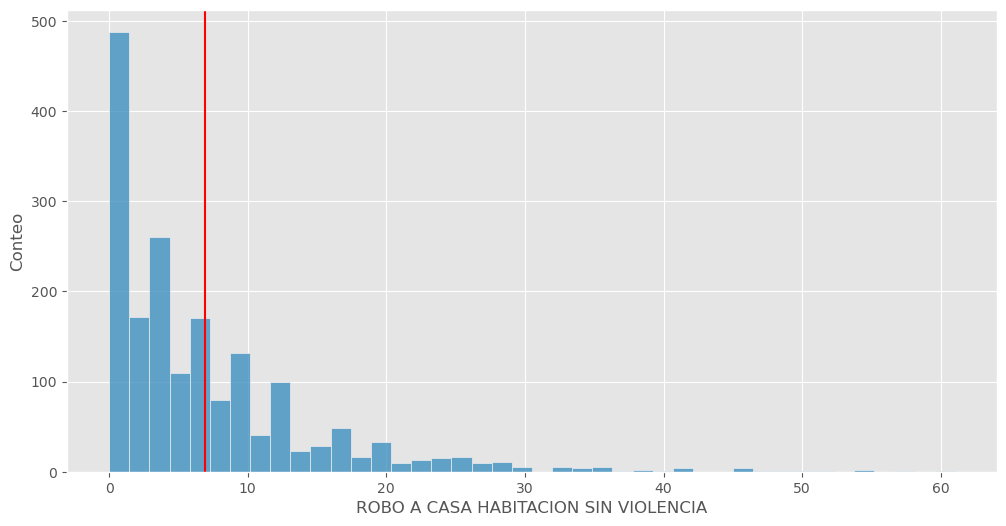

In [ ]:
ax = ca_censo.displot_Y()

También podemos ver una descripción de los datos

In [ ]:
ca_censo.describe_Y()

/home/plablo/git/criminologia_cdmx/criminologia_cdmx/modelos.py:185: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(v)


,
Estadístico,
N,1815.000000
Media,6.919559
Varianza,64.496282
Desviación estándar,8.030958
Mínimo,0.000000
25%,1.000000
50%,4.000000
75%,10.000000
Máximo,61.000000


También podemos ver un mapa de la variable dependiente

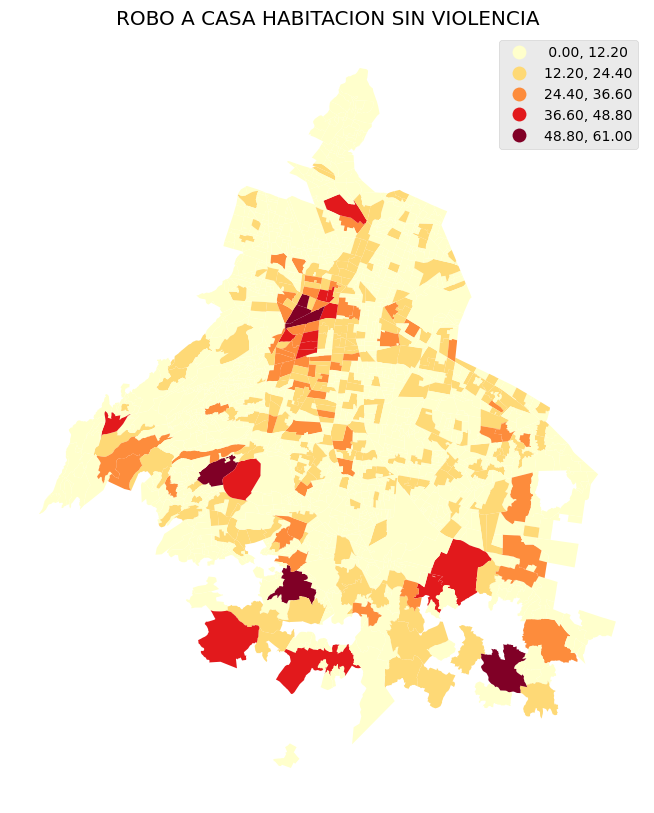

In [ ]:
ax = ca_censo.mapa_Y('colonias', clasificacion='equal_interval')

Para las variables dependientes podemos ver una gráfica de la dispersión por pares

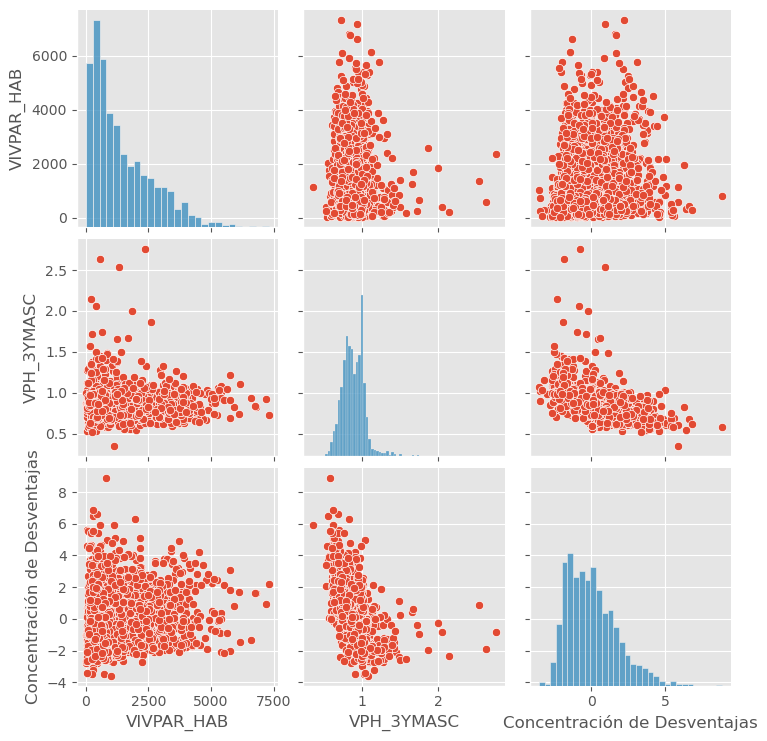

In [ ]:
g = ca_censo.pairplot_X()

O un mapa de cualquiera de ellas

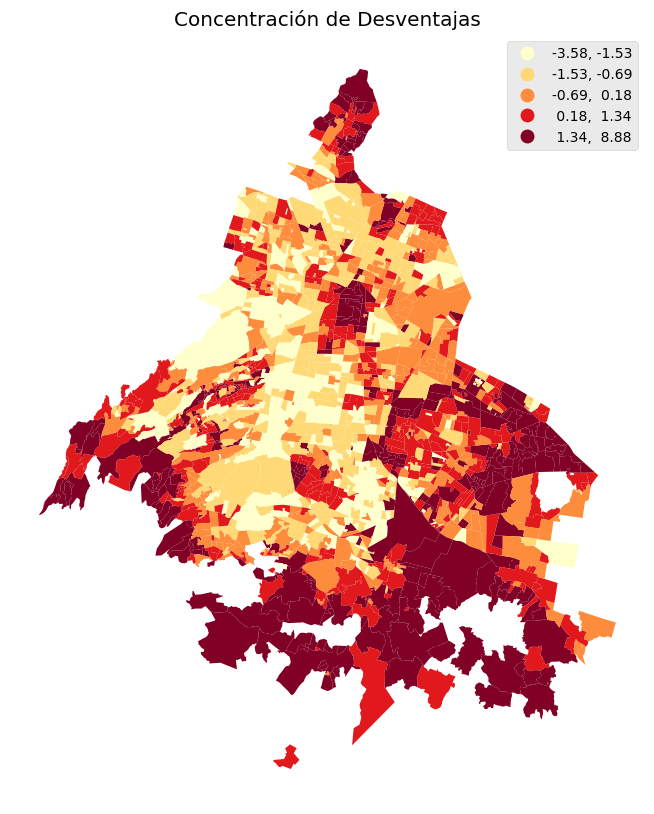

In [ ]:
ax = ca_censo.mapa_X('Concentración de Desventajas', 'colonias', clasificacion='quantiles')

#### Ajuste del primer modelo

Ya tenemos preparados nuestros datos con variables censales, ahora podemos construir y ajustar el modelo.

**NOTA:** Aquí puede haber discrepancias en el número de unidades porque `CapaDeAnalisis` tira las observaciones que tienen algún nulo (en las covariables). Eso puede ser real o puede haber algún error en el proceso. 

In [ ]:
m_censo = ModeloGLM(ca_censo, sm.families.NegativeBinomial(), 'Nulo')
r_censo = m_censo.fit()
r_censo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     Q('ROBO A CASA HABITACION SIN VIOLENCIA')   No. Observations:                 1798
Model:                                                   GLM   Df Residuals:                     1794
Model Family:                               NegativeBinomial   Df Model:                            3
Link Function:                                           Log   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4875.9
Date:                                       Mon, 29 Aug 2022   Deviance:                       1217.4
Time:                                               10:19:41   Pearson chi2:                     974.
No. Iterations:                                           11   Pseudo R-squ. (CS):             0.4508
Covariance Type:                                   nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2124      0.164     -1.295      0.195      -0.534       0.109
Q('VIVPAR_HAB')                       0.0007   2.07e-05     33.501      0.000       0.001       0.001
Q('VPH_3YMASC')                       0.9152      0.179      5.125      0.000       0.565       1.265
Q('Concentración de Desventajas')    -0.0317      0.019     -1.648      0.099      -0.069       0.006
=====================================================================================================
"""

#### Diagnósticos
Para ayudar a diagnosticar el modelo,  además del resumen, podemos ver algunas gráficas sobre el ajuste

Gráfica de Ajuste del Modelo: Diagrama de dispersión (con línea de ajuste) de valores observados contra predichos.

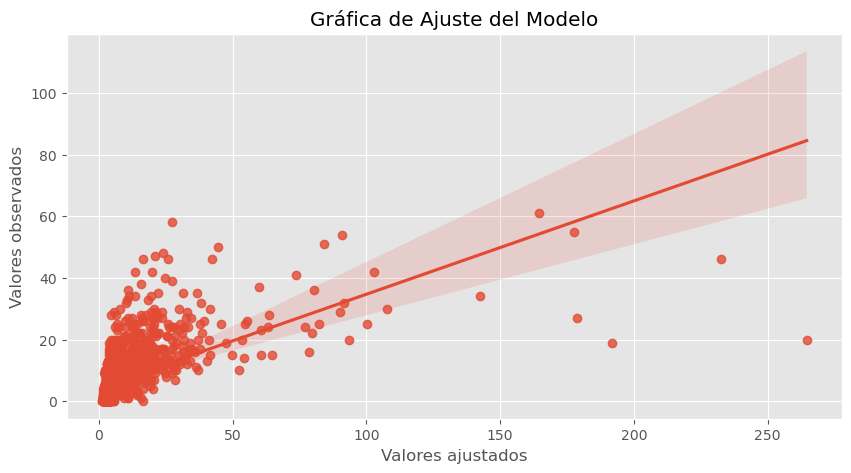

In [ ]:
ax = m_censo.grafica_de_ajuste()

Residuales contra valores ajustados

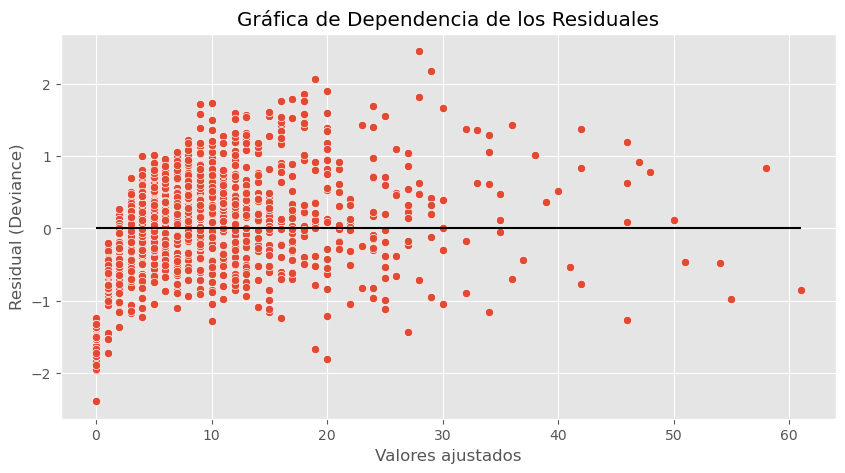

In [ ]:
ax = m_censo.grafica_residuales()

Histograma de residuales

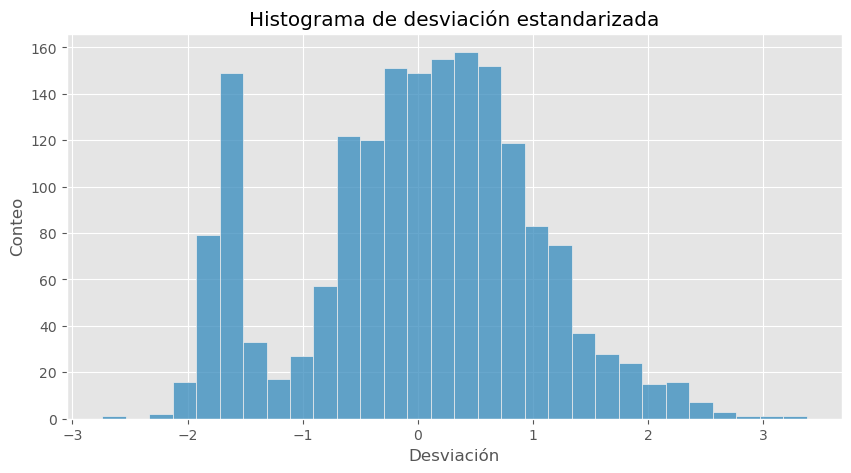

In [ ]:
ax = m_censo.histograma_deviance()

Mapa de residuales

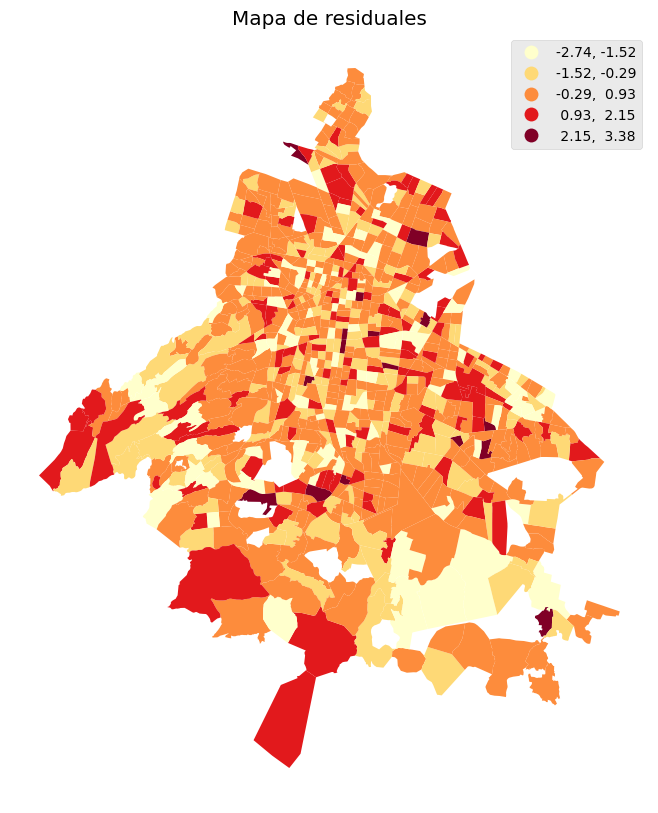

In [ ]:
ax = m_censo.mapa_residuales(clasificacion="equal_interval")

Diagrama de dispersión de Moran de los residuales

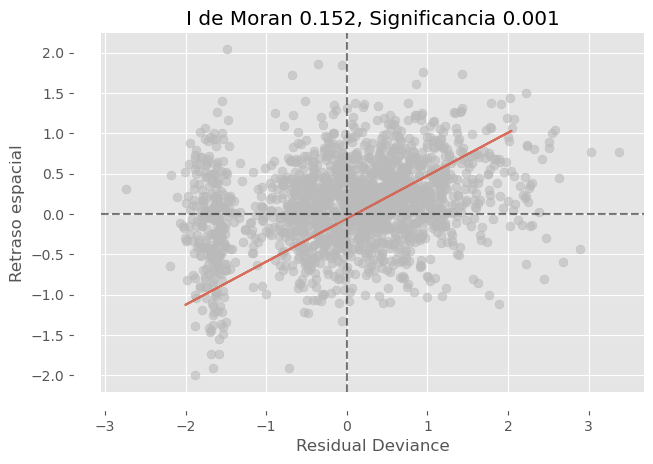

In [ ]:
ax = m_censo.scatterpĺot_moran()

### Variables de uso de suelo

Ahora preparamos otro conjunto al que le vamos a pegar las variables de uso de suelo

In [ ]:
usos = get_uso_de_suelo()
usos = agrega_uso_suelo(usos, unidades='colonias')
usos.head()

/home/plablo/miniconda3/envs/criminologia/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Industria,Comercio,Servicios,Intensidad,Entropía
colonia_cve,,,,,
1,8,87,44,139,-4.072303
2,15,112,55,182,-3.803105
3,2,22,7,31,-4.161488
4,9,55,31,95,-3.661970
5,31,144,66,241,-3.514375


In [ ]:
var_m2 = var_m1.join(usos)
var_m2.head()

,VIVPAR_HAB,VPH_3YMASC,Concentración de Desventajas,Industria,Comercio,Servicios,Intensidad,Entropía
colonia_cve,,,,,,,,
0,1825.0,0.790137,2.381361,NaN,NaN,NaN,NaN,NaN
1,607.0,0.762768,-0.951390,8.0,87.0,44.0,139.0,-4.072303
2,1030.0,0.793204,-0.889063,15.0,112.0,55.0,182.0,-3.803105
3,803.0,0.911582,-1.186893,2.0,22.0,7.0,31.0,-4.161488
4,1347.0,0.783222,-0.485463,9.0,55.0,31.0,95.0,-3.661970


También creamos la capa de análisis y la inspeccionamos

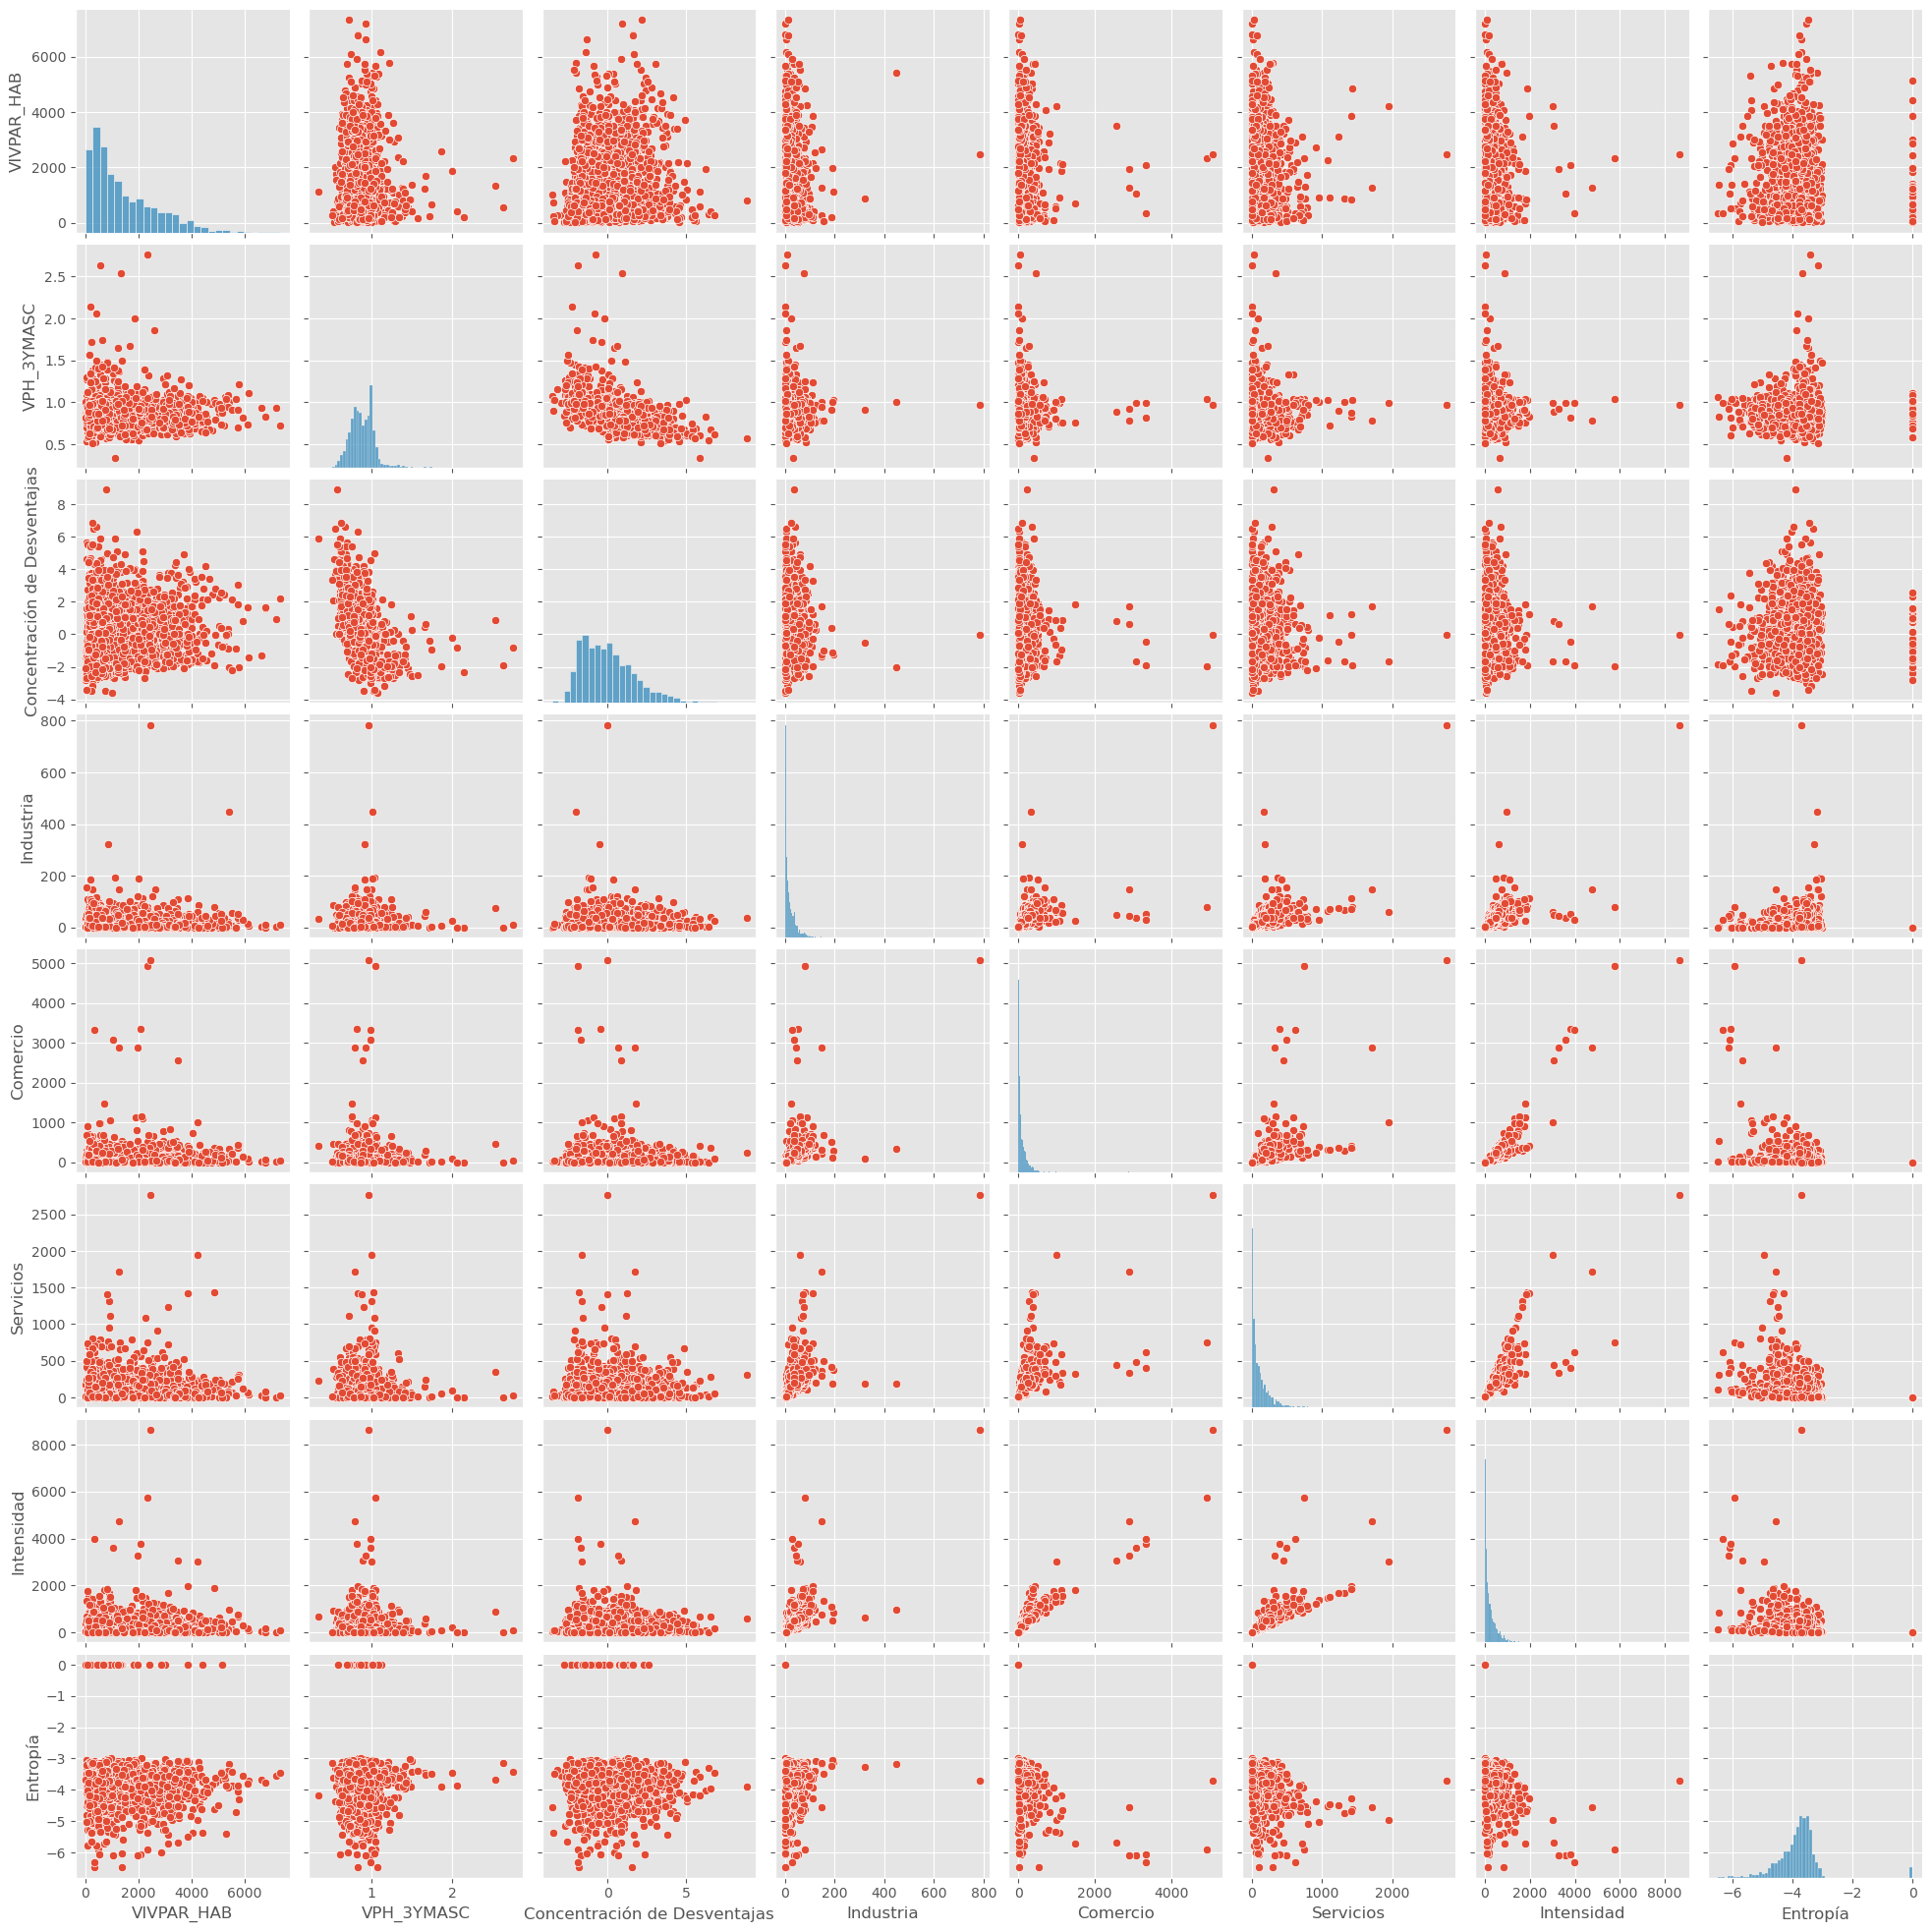

In [ ]:
ca_uso_suelo = CapaDeAnalisis(Y, var_m2, 'colonias')
g = ca_uso_suelo.pairplot_X(14,1)

La verdad, parece que la variable intensidad no nos está aportando mucho (es sólo la suma de los usos de suelo), entonces la podemos quitar de los datos y recrear la capa

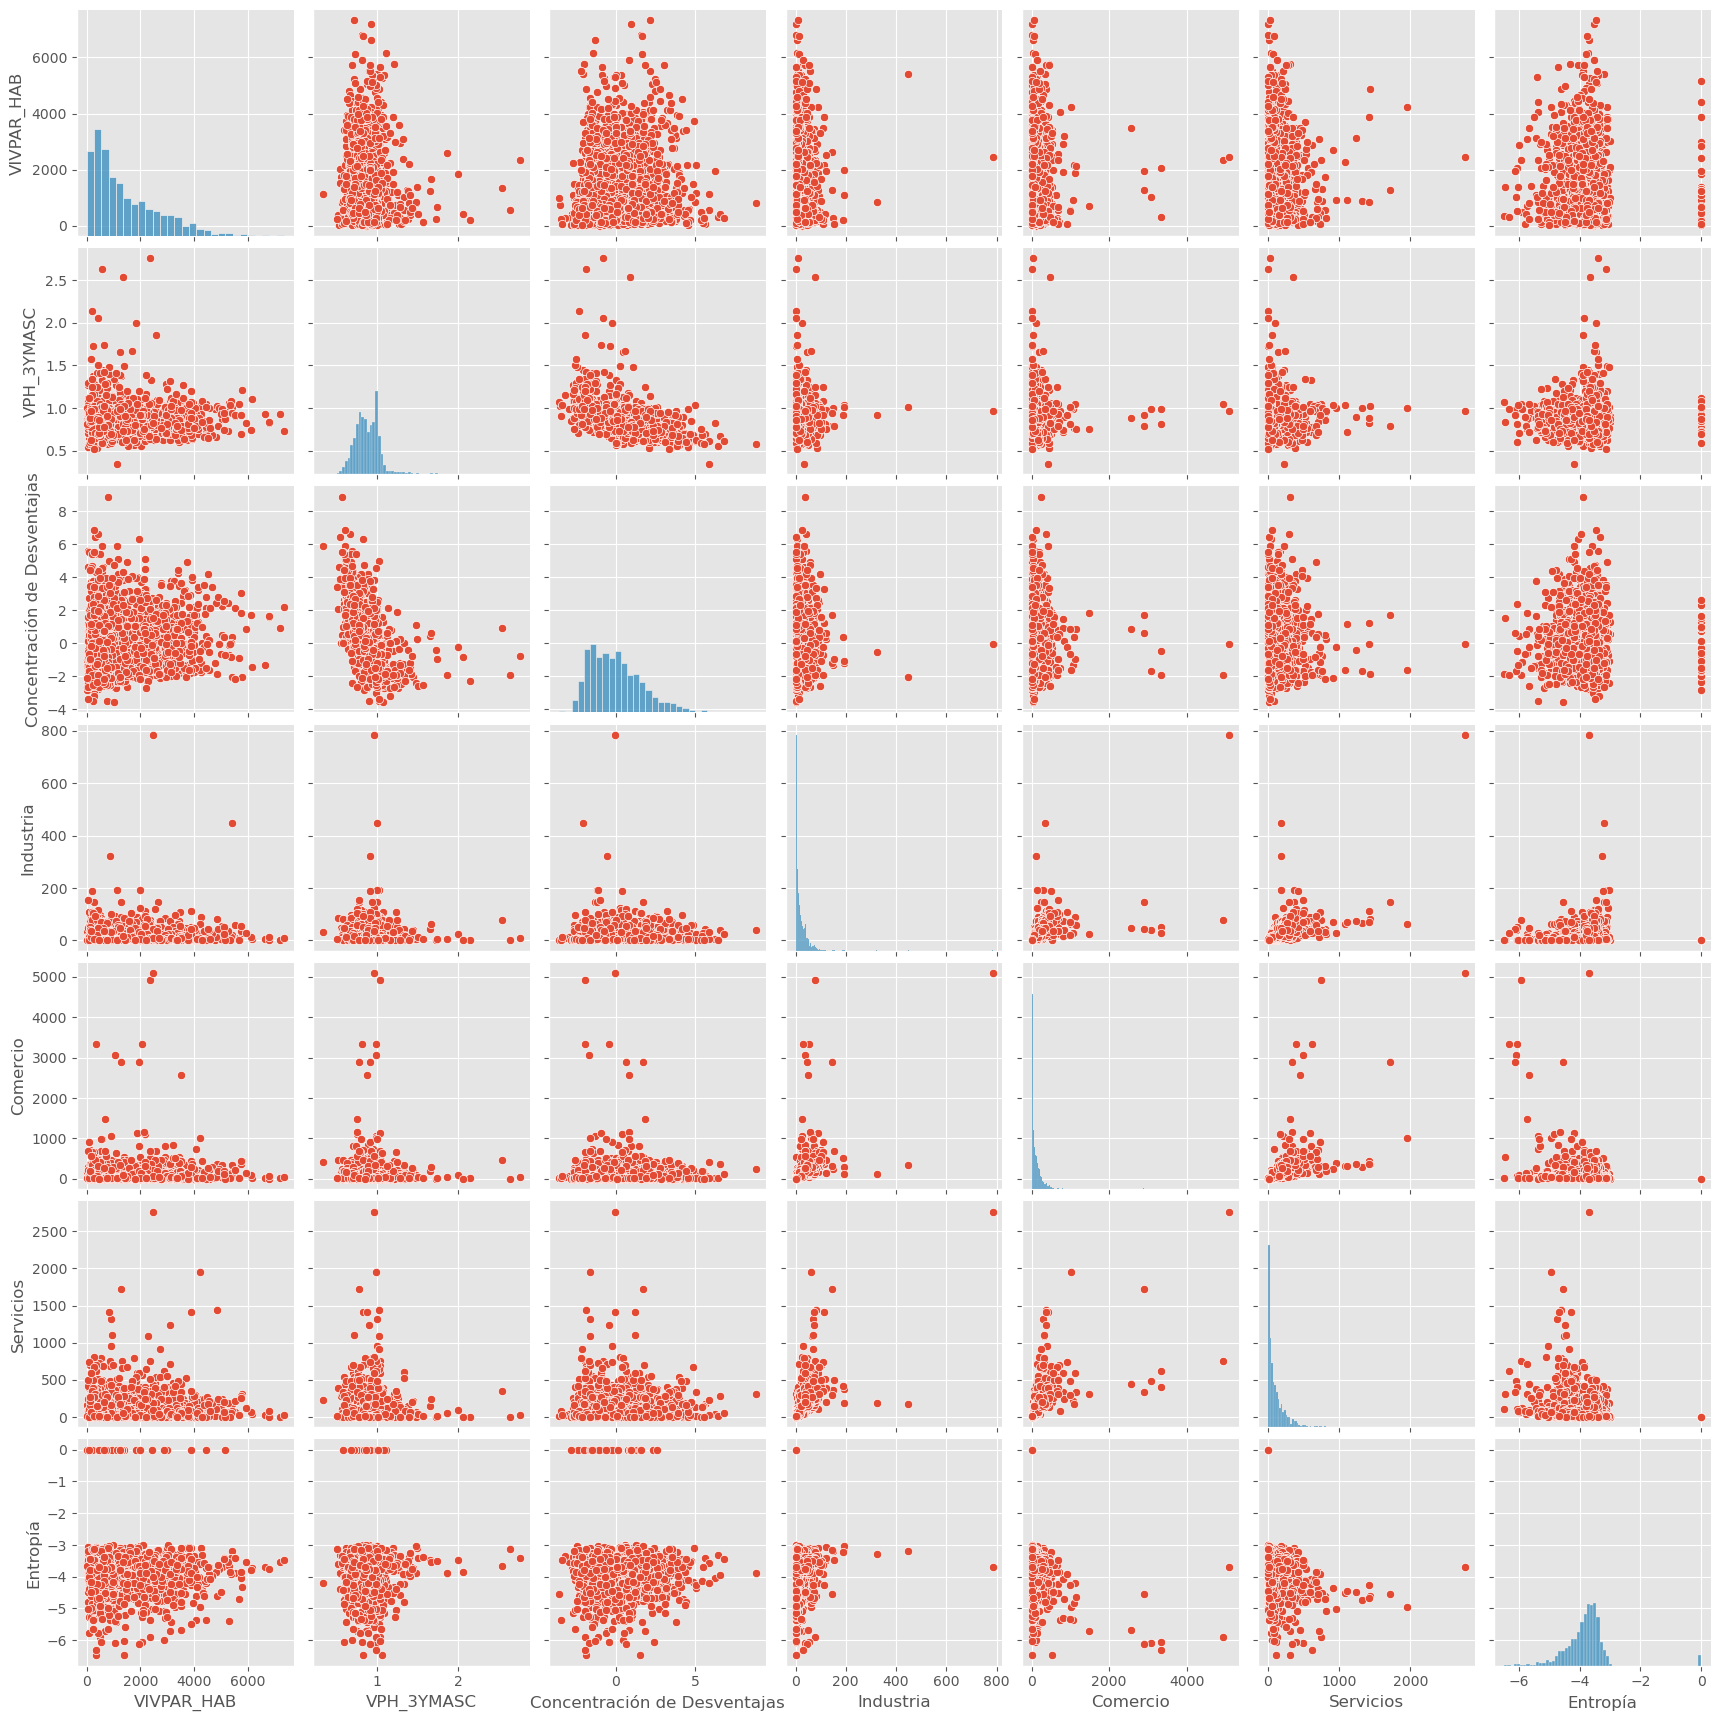

In [ ]:
var_m2 = var_m2.drop(columns='Intensidad')
ca_uso_suelo = CapaDeAnalisis(Y, var_m2, 'colonias')
g = ca_uso_suelo.pairplot_X(14,1)

#### Ajuste del segundo modelo

In [ ]:
m_suelo = ModeloGLM(ca_uso_suelo, sm.families.NegativeBinomial(), "Uso de Suelo")
r_suelo = m_suelo.fit()
r_suelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     Q('ROBO A CASA HABITACION SIN VIOLENCIA')   No. Observations:                 1596
Model:                                                   GLM   Df Residuals:                     1588
Model Family:                               NegativeBinomial   Df Model:                            7
Link Function:                                           Log   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4318.7
Date:                                       Mon, 29 Aug 2022   Deviance:                       1091.3
Time:                                               10:21:53   Pearson chi2:                     880.
No. Iterations:                                           11   Pseudo R-squ. (CS):             0.4591
Covariance Type:                                   nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2801      0.234     -1.199      0.230      -0.738       0.178
Q('VIVPAR_HAB')                       0.0007   2.19e-05     31.908      0.000       0.001       0.001
Q('VPH_3YMASC')                       0.9227      0.188      4.899      0.000       0.554       1.292
Q('Concentración de Desventajas')    -0.0347      0.020     -1.704      0.088      -0.075       0.005
Q('Industria')                        0.0014      0.001      1.148      0.251      -0.001       0.004
Q('Comercio')                     -1.257e-05      0.000     -0.100      0.921      -0.000       0.000
Q('Servicios')                    -2.994e-05      0.000     -0.134      0.893      -0.000       0.000
Q('Entropía')                        -0.0051      0.042     -0.122      0.903      -0.086       0.076
=====================================================================================================
"""

## Comparación de modelos

Para poder comparar fácilmente modelos, tenemos la clase `ComparaModelos` que nos ayuda a ver los resultados de forma sencilla.

Primero instanciamos el objeto:

In [ ]:
compara = ComparaModelos([m_censo,m_suelo], ['coef', 'P>|z|'], 3)

Podemos ver una tabla comparando el resultado de los modelos

In [ ]:
compara.comparacion

Modelo Nulo        Modelo Uso de Suelo  \
                                         coef  P>|z|                coef   
Q('Servicios')                            NaN    NaN              -0.000   
Q('Comercio')                             NaN    NaN              -0.000   
Q('Entropía')                             NaN    NaN              -0.005   
Intercept                              -0.212  0.195              -0.280   
Q('Concentración de Desventajas')      -0.032  0.099              -0.035   
Q('VIVPAR_HAB')                         0.001  0.000               0.001   
Q('VPH_3YMASC')                         0.915  0.000               0.923   
Q('Industria')                            NaN    NaN               0.001   

                                          
                                   P>|z|  
Q('Servicios')                     0.893  
Q('Comercio')                      0.921  
Q('Entropía')                      0.903  
Intercept                          0.230  
Q('Concentración de Desventajas')  0.088  
Q('VIVPAR_HAB')                    0.000  
Q('VPH_3YMASC')                    0.000  
Q('Industria')                     0.251

O también los diagnósticos

In [ ]:
compara.diagnosticos

,Diagnóstico,Valor Modelo Nulo,Valor Modelo Uso de Suelo
0,Log-Likelihood,-4875.944,-4318.720
1,Deviance,1217.438,1091.271
2,Pearson chi2,974.489,879.609


La clase provee métodos para inspeccionar las mismas gráficas de diagnóstico que `ModeloGLM`

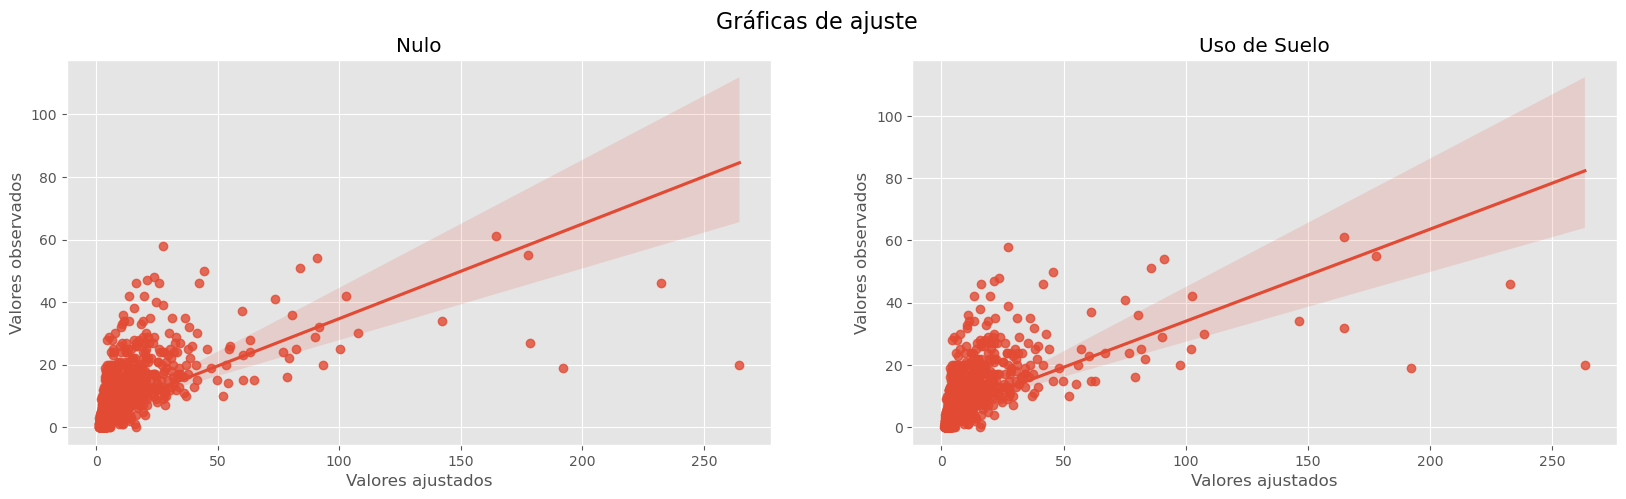

In [ ]:
compara.graficas_de_ajuste()

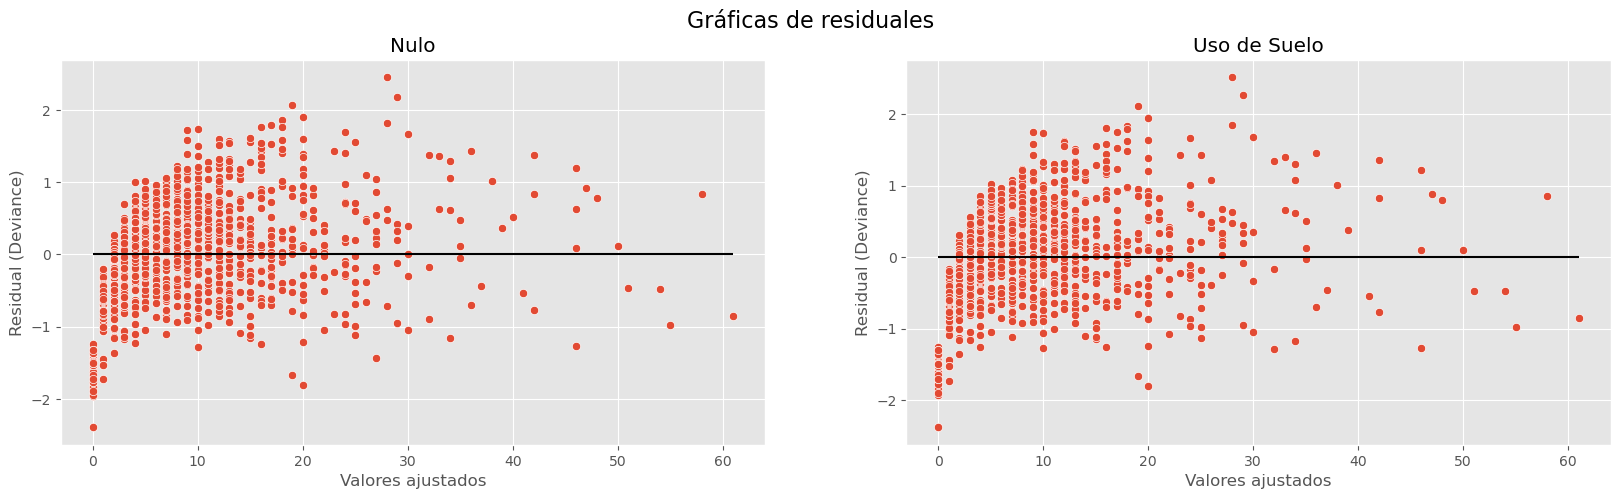

In [ ]:
compara.graficas_residuales()

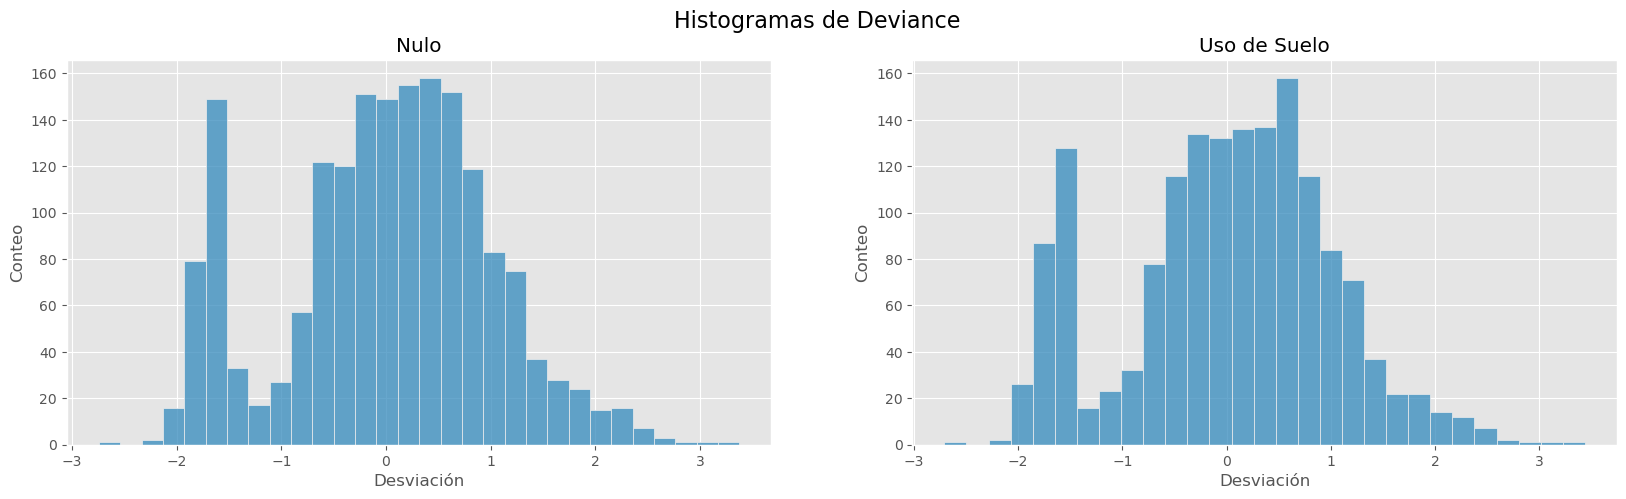

In [ ]:
compara.histogramas_deviance()

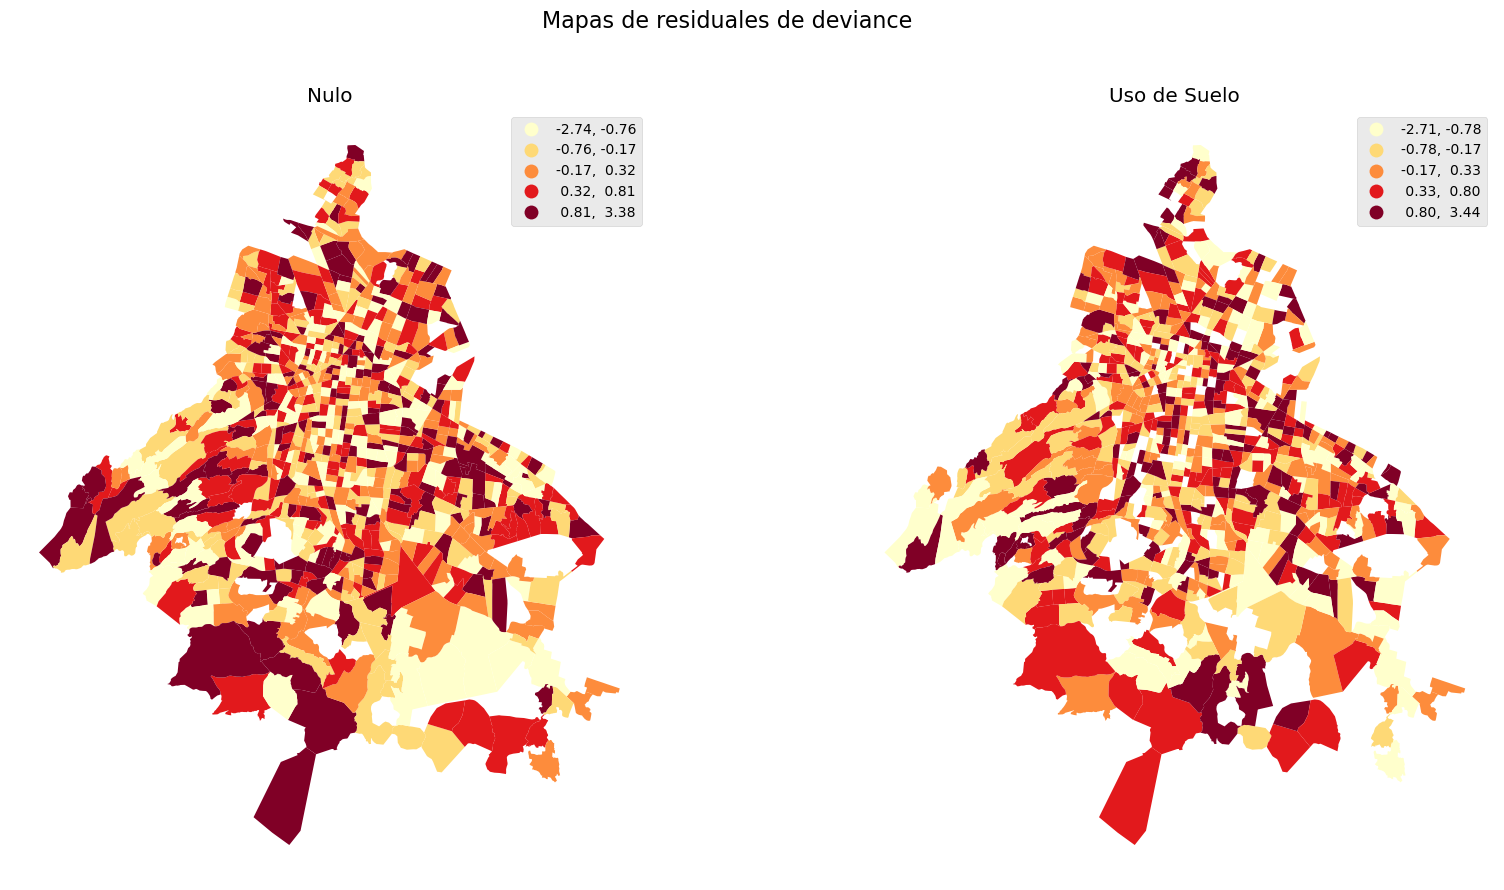

In [ ]:
compara.mapas_residuales()

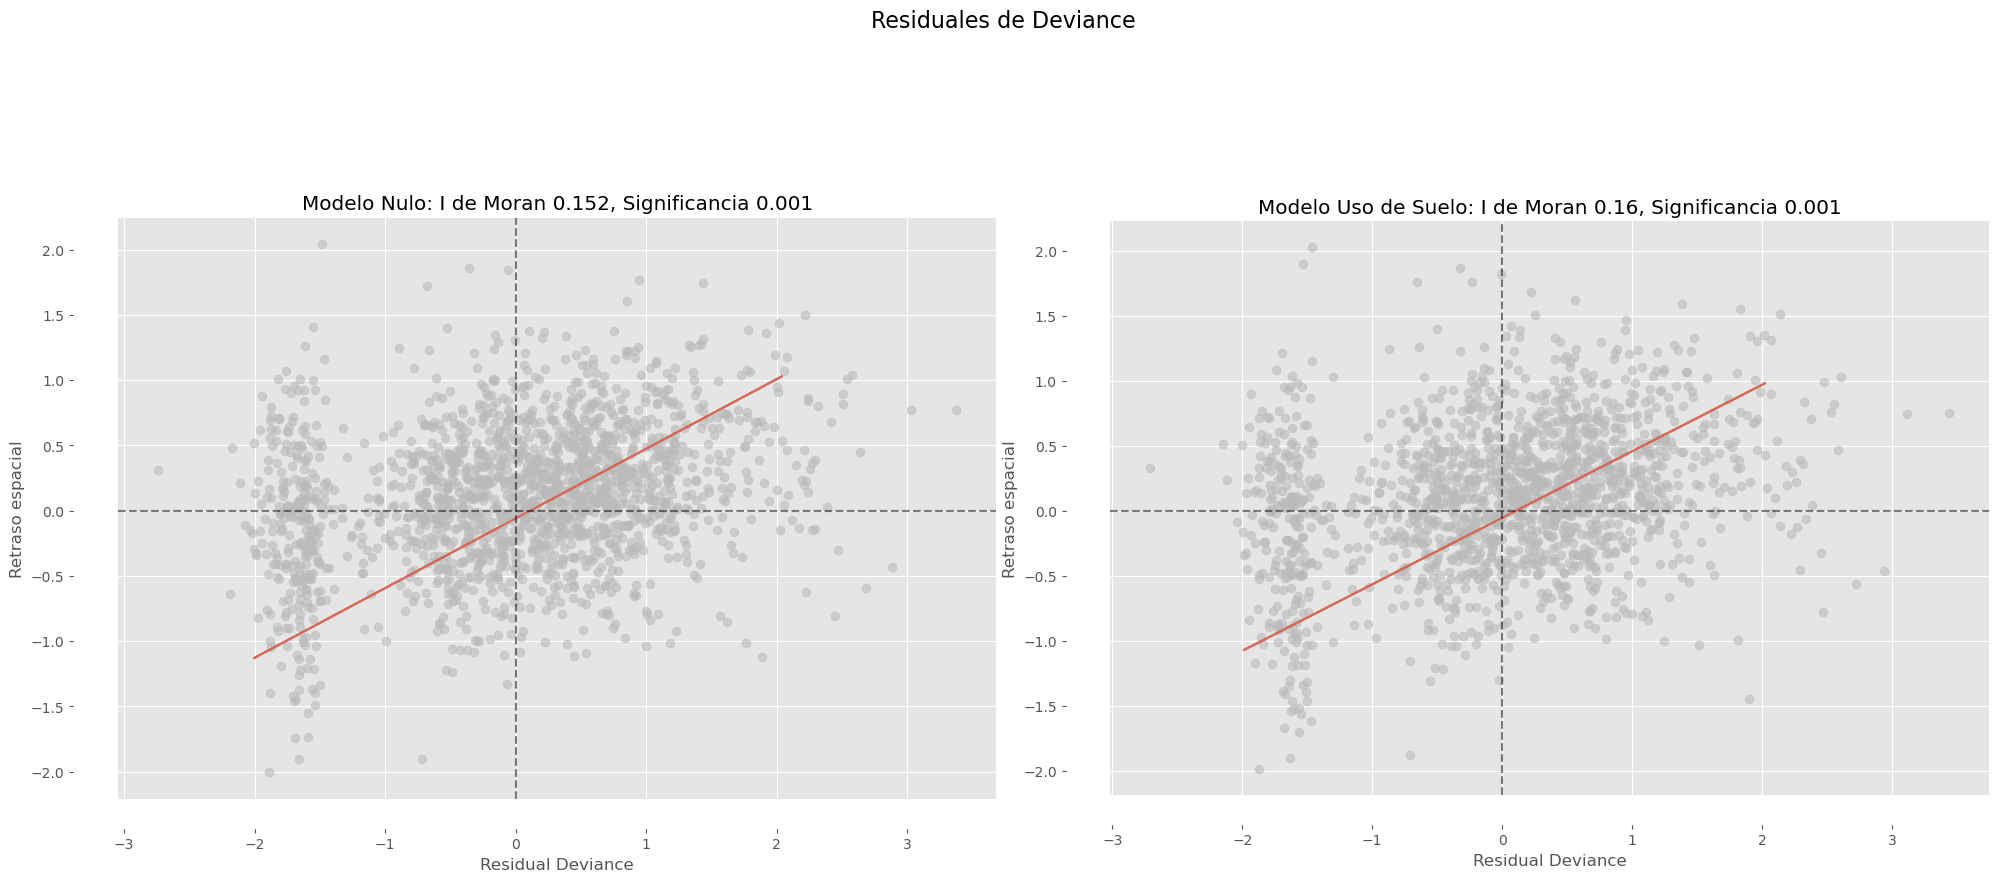

In [ ]:
compara.scatterpĺots_moran()